In [2]:
import numpy as np
import matplotlib.pyplot as plt
import baccoemu

2024-02-05 11:33:21.371956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 11:33:24.859682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/scratch/mzennaro/miniconda3/envs/mcnd/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def combine(biasvec, pnn):
    import itertools
    biasvec = np.concatenate([[1], biasvec])
    prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))
    pgg = 0
    pgm = 0
    for i in range(15):
        fac = 2 if prod[i, 0] != prod[i, 1] else 1
        pgg += fac * biasvec[prod[i, 0]] * biasvec[prod[i, 1]] * pnn[i]
        if i < 5:
            pgm += biasvec[prod[i, 0]] * biasvec[prod[i, 1]] * pnn[i]
    return pgg, pgm

In [4]:
def mn_kmax(kmax, dmo=True):
    import os
    os.environ['OMP_NUM_THREADS'] = '1'
    from pymultinest.solve import solve
    from pymultinest import Analyzer

    import pickle
    with open('pij.pickle', 'rb') as f:
        pij = pickle.load(f)

    k = pij['dmopij'][0]['k']
    if dmo:
        pnn = [pij['dmopij'][i]['pk'] for i in range(len(pij['dmopij']))]
    else:
        pnn = [pij['bcmpij'][i]['pk'] for i in range(len(pij['bcmpij']))]

    fname = 'nenya_z0_pgg_pgm_pgm_bcm.pickle'
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    pggdata = data['pgg']
    pgmdata = data['pgm_bcm']
    k = pggdata['k']
    pgg = pggdata['pk']
    pgm = pgmdata['pk']
    mask = k < kmax
    k = k[mask]
    pgg = pgg[mask]
    pgm = pgm[mask]
    ndens = 1 / np.mean(pggdata['shotnoise'][pggdata['shotnoise'] > 0])
    print('ndens', ndens)

    Nk = pggdata['nmodes'][mask]
    pgg_err = np.sqrt(2 / Nk) * pgg
    pgg_err = np.sqrt(pgg_err**2 + (0.005 * pgg)**2)
    pgm_err = np.sqrt(2 / Nk) * pgm
    pgm_err = np.sqrt(pgm_err**2 + (0.005 * pgm)**2)

    parameters = ['b1', 'b2', 'sb2', 'blap', 'Asn']
    latex = [r'b_{1}', r'b_2', r'b_{s^2}', r'b_{\nabla^2\delta}', r'A_{\rm sn}']
    bounds = [[-5, 5], [-5, 5], [-20, 20], [-1000, 1000], [0, 3]]

    def chi2_func(theta):
        b1, b2, bs2, blap, Asn = theta

        pgg_model, pgm_model = combine([b1, b2, bs2, blap], pnn)

        pgg_model += Asn / ndens

        pgg_model = pgg_model[mask]
        pgm_model = pgm_model[mask]

        # print(b1, b2, bs2, blap, Asn)
        # print(pgg.shape)
        # print(pgg_model.shape)
        # print(pgg_err.shape)

        return np.sum(((pgg - pgg_model) / pgg_err)**2) + np.sum(((pgm - pgm_model) / pgm_err)**2)

    def myprior(cube):
        for i in range(len(parameters)):
            cube[i] = cube[i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0] # uniform linear priors
        return cube

    def myloglike(cube):
        chi2 = chi2_func(cube)
        return -0.5 * chi2

    os.system('mkdir -p .mpk_chains_fixed_ns')
    outputfiles_basename = '.mpk_chains_fixed_ns/test'

    result = solve(LogLikelihood=myloglike,
                   Prior=myprior,
                   n_dims=len(parameters),
                   n_params=len(parameters),
                   outputfiles_basename=outputfiles_basename,
                   evidence_tolerance=0.1,
                   n_live_points=400,
                   resume=False,
                   use_MPI=False,
                   verbose=True)
    a = Analyzer(len(parameters), outputfiles_basename=outputfiles_basename)
    stats = a.get_stats()
    bestfit_params = a.get_best_fit()
    samples = a.get_data()
    return {'kmax' : kmax, 'result' : result, 'samples' : samples, 'stats' : stats, 'bestfit' : bestfit_params,
            'bounds' : bounds, 'parameters' : parameters, 'latex' : latex, 'pk' : pgg, 'pk_err' : pgg_err, 'pgm' : pgm, 'pgm_err' : pgm_err}

In [5]:
import os
import pickle
kmaxes = [0.1, 0.2, 0.35, 0.5, 0.75]
mn = []
for kmax in kmaxes:
    fname = f'mn_fits_kmax{kmax}_z0_correctEmuErr_0p5perc_pgg_pgm_dmo.pickle'
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            _mn = pickle.load(f)
        mn.append(_mn['mn'])
    else:
        _mn = mn_kmax(kmax, dmo=True)
        mn.append(_mn)
        with open(fname, 'wb') as f:
            pickle.dump({'mn' : _mn}, f)

In [6]:
import os
import pickle
kmaxes = [0.1, 0.2, 0.35, 0.5, 0.75]
mnbcm = []
for kmax in kmaxes:
    fname = f'mn_fits_kmax{kmax}_z0_correctEmuErr_0p5perc_pgg_pgm_bcm.pickle'
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            _mn = pickle.load(f)
        mnbcm.append(_mn['mn'])
    else:
        _mn = mn_kmax(kmax, dmo=False)
        mnbcm.append(_mn)
        with open(fname, 'wb') as f:
            pickle.dump({'mn' : _mn}, f)

In [7]:
from getdist import MCSamples, plots

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


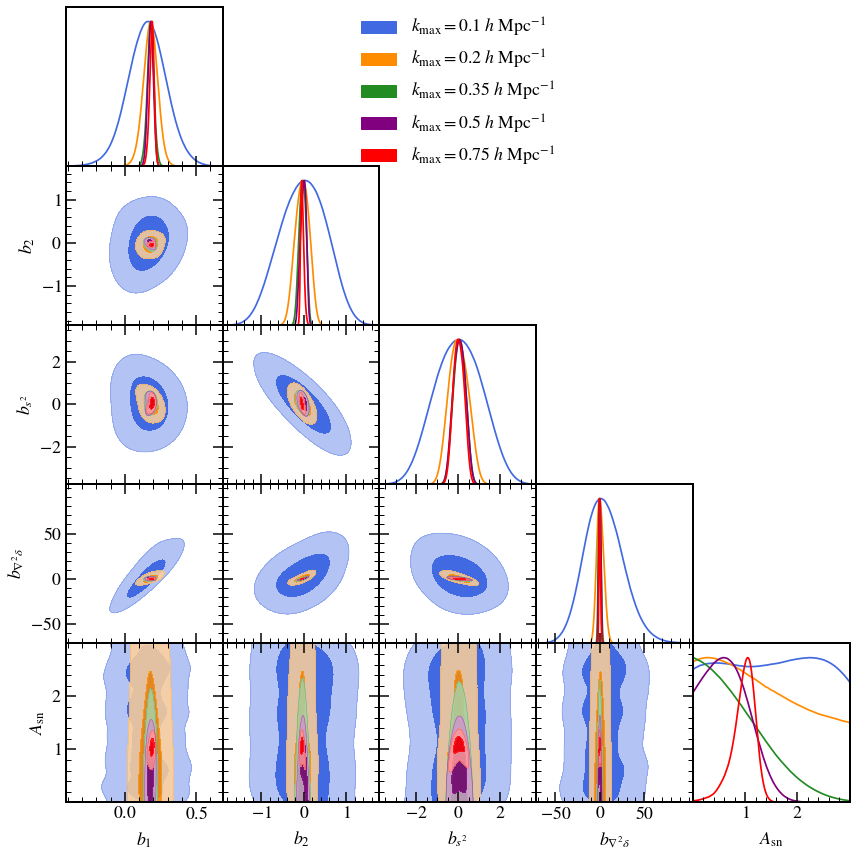

In [8]:
%matplotlib inline

gd_samples = []
for chain in mn:

    if chain['kmax'] > 0.9:
        continue

    bounds = {name : bound for name, bound in zip(chain['parameters'], chain['bounds'])}
    labels = chain['latex']
    samples = chain['samples'][:,2:]
    weights = chain['samples'][:,0]
    loglikes = chain['samples'][:,1]
    bestfits = chain['bestfit']['parameters']
    gd_samples.append(MCSamples(samples=samples, weights=weights, loglikes=loglikes,
                           label=r'$k_{\rm max} = %g \,\, h \,\, \mathrm{Mpc}^{-1}$'%(chain['kmax']),
                           names=chain['parameters'], labels=labels, ranges=bounds))
contour_args = {'contour_levels' : [np.exp(-0.5), np.exp(-2)]}

g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 20
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.fig_width_inch = 12
g.settings.linewidth = 2.5
g.settings.tight_layout = True
g.triangle_plot(gd_samples, filled=True, contour_colors=['royalblue','darkorange','forestgreen','purple','red'], contour_args=contour_args)

truths = None

# truths = [0.27, np.log(1e10*2.11065e-9), 0.049, 0.67]

if truths is not None:
    lw = 2
    for i in range(len(truths)):
        for j in range(i):
            g.subplots[i,j].axhline(truths[i], color='k', ls='--', lw=lw)
            g.subplots[i,j].axvline(truths[j], color='k', ls='--', lw=lw)
#             g.subplots[i,j].plot([bestfits[j]], [bestfits[i]], lw=0, ms=15, marker='*', mec='k', color='yellow')

    for i in range(len(truths)):
        g.subplots[i,i].axvline(truths[i], color='k', ls='--', lw=lw)

for i in range(g.subplots.shape[0]):
    g.subplots[i,i].tick_params(axis='y', which='minor', left=False)
# plt.suptitle(r'scaled volume cosmic variance + 2% theory error', fontsize=20, y=1.03)
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


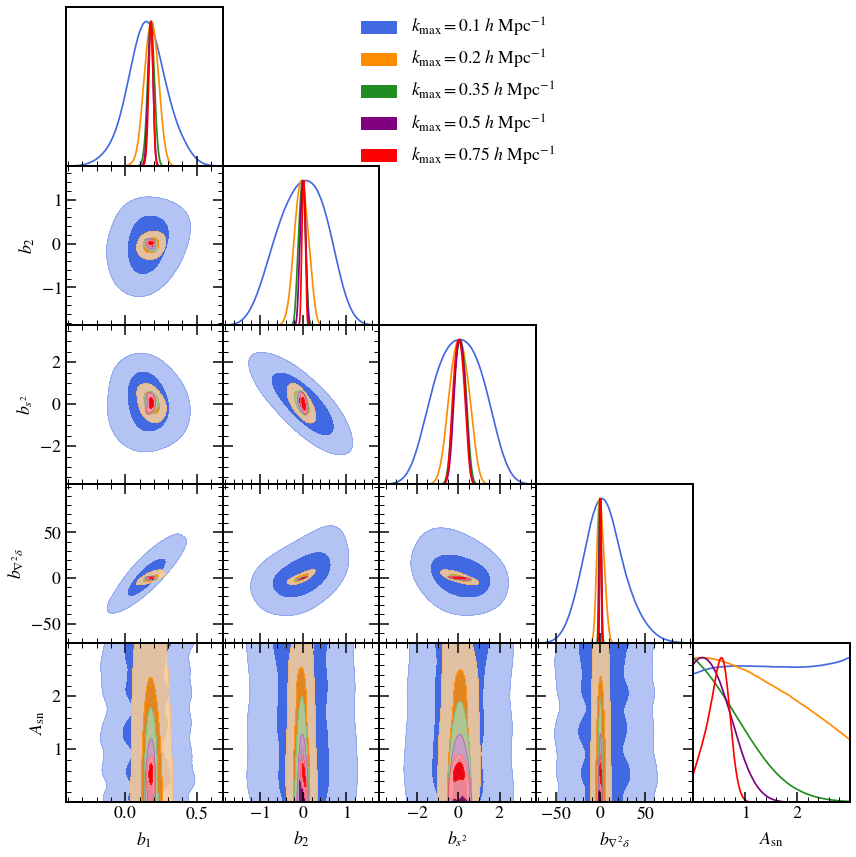

In [9]:
%matplotlib inline

gd_samples = []
for chain in mnbcm:

    if chain['kmax'] > 0.9:
        continue

    bounds = {name : bound for name, bound in zip(chain['parameters'], chain['bounds'])}
    labels = chain['latex']
    samples = chain['samples'][:,2:]
    weights = chain['samples'][:,0]
    loglikes = chain['samples'][:,1]
    bestfits = chain['bestfit']['parameters']
    gd_samples.append(MCSamples(samples=samples, weights=weights, loglikes=loglikes,
                           label=r'$k_{\rm max} = %g \,\, h \,\, \mathrm{Mpc}^{-1}$'%(chain['kmax']),
                           names=chain['parameters'], labels=labels, ranges=bounds))
contour_args = {'contour_levels' : [np.exp(-0.5), np.exp(-2)]}

g = plots.get_subplot_plotter()
g.settings.lab_fontsize = 20
g.settings.axes_fontsize = 20
g.settings.legend_fontsize = 20
g.settings.fig_width_inch = 12
g.settings.linewidth = 2.5
g.settings.tight_layout = True
g.triangle_plot(gd_samples, filled=True, contour_colors=['royalblue','darkorange','forestgreen','purple','red'], contour_args=contour_args)

truths = None

# truths = [0.27, np.log(1e10*2.11065e-9), 0.049, 0.67]

if truths is not None:
    lw = 2
    for i in range(len(truths)):
        for j in range(i):
            g.subplots[i,j].axhline(truths[i], color='k', ls='--', lw=lw)
            g.subplots[i,j].axvline(truths[j], color='k', ls='--', lw=lw)
#             g.subplots[i,j].plot([bestfits[j]], [bestfits[i]], lw=0, ms=15, marker='*', mec='k', color='yellow')

    for i in range(len(truths)):
        g.subplots[i,i].axvline(truths[i], color='k', ls='--', lw=lw)

for i in range(g.subplots.shape[0]):
    g.subplots[i,i].tick_params(axis='y', which='minor', left=False)
# plt.suptitle(r'scaled volume cosmic variance + 2% theory error', fontsize=20, y=1.03)
plt.show()